* Extract cofactors (NADPH, NADH, ATP) balances
nadphs = ['nadph_c', 'nadph_m', 'nadph_x']
nadhs = ['nadh_c', 'nadh_m', 'nadh_x', 'nadh_r']
atps = ['atp_c', 'atp_m', 'atp_v', 'atp_n', 'atp_r'] 
* Include their all reactions (ID, name, equation) and  the cofactor balance in that reaction (flux) and % of total consumed/produced cofactor flux

In [1]:
import cobra
import pandas as pd
import os
from os.path import join
from cobra import Model, Reaction, Metabolite
from cobra.sampling import sampling
import numpy as np
os.environ["R_HOME"] = f"{os.environ['CONDA_PREFIX']}\\Lib\\R"
import rpy2.robjects
from plotnine import *
import matplotlib.pyplot as plt

model=cobra.io.read_sbml_model("C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Model_files\\Rt_IFO0880_jsb.xml")
model.objective = "BIOMASS_RT" 

Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-21


In [2]:
glucose_uptakes= [0.476, 1.114, 1.648, 2.305, 2.6619851, 3.1] # the fifth glc uptake value was calculated

# medium = model.medium
# medium["EX_glc__D_e"] = glucose_uptakes[3]
# model.medium = medium
solution = model.optimize()

In [3]:
# Cofactor lists
nadphs = ['nadph_c', 'nadph_m', 'nadph_x']
nadhs = ['nadh_c', 'nadh_m', 'nadh_x', 'nadh_r']
atps = ['atp_c', 'atp_m', 'atp_v', 'atp_n', 'atp_r'] 

In [4]:
# Make a function for getting cofactor fluxes (all reactions where given metabolite is and their fluxes)

def cofactor_all_rxn_fluxes(cofactor_list, glucose_uptake):
    producing_fluxes = pd.DataFrame() 
    consuming_fluxes = pd.DataFrame()

    medium = model.medium
    medium["EX_glc__D_e"] = glucose_uptake
    model.medium = medium
        
    solution = model.optimize()
    biomass_GR = solution.objective_value
    print(f'Biomass growth rate: {biomass_GR}')
    for metabolite in cofactor_list:
        producing_fluxes = pd.concat([producing_fluxes, getattr(model.metabolites, metabolite).summary().producing_flux])
        consuming_fluxes = pd.concat([consuming_fluxes, getattr(model.metabolites, metabolite).summary().consuming_flux])
    
    for reaction in producing_fluxes.index:
        if reaction in consuming_fluxes.index and abs(round(producing_fluxes.loc[reaction, 'flux'], 3)) == abs(round(consuming_fluxes.loc[reaction, 'flux'], 3)):
            producing_fluxes = producing_fluxes.drop([reaction])
            consuming_fluxes = consuming_fluxes.drop([reaction])
            
    cofactor_fluxes = pd.concat([producing_fluxes, consuming_fluxes])

    cofactor_fluxes = cofactor_fluxes.sort_values(by='flux', ascending=False).drop(columns = ['percent']) # drop percent column, bc these percents are not for nadph sum (the percent is for specific compartment)
    cofactor_fluxes = cofactor_fluxes[(cofactor_fluxes['flux']) != 0.0] # for getting non-zero fluxes only

    cofactor_sum_producing_flux = sum(cofactor_fluxes[cofactor_fluxes['flux'] > 0]['flux']) # for getting the sum of producing fluxes
    cofactor_sum_consuming_flux = sum(cofactor_fluxes[cofactor_fluxes['flux'] < 0]['flux']) # for getting the sum of consumed fluxes
    print(f'SUM produced: {cofactor_sum_producing_flux}, SUM consumed: {cofactor_sum_consuming_flux}')

    if round(cofactor_sum_producing_flux, 3) == round(abs(cofactor_sum_consuming_flux), 3):
        cofactor_fluxes['percent'] = abs(cofactor_fluxes['flux']/cofactor_sum_producing_flux) # add percent column

    return cofactor_fluxes, biomass_GR

In [15]:
# Making a pie chart
def cofactor_fluxes_pie_chart(cofactor_fluxes,  title, threshold): # threshold shows the percent of the flux for including in others sector on pie chart 
    # The three lines below are for grouping together reactions with low fluxes in producing
    producing_cofactor_fluxes_draw = cofactor_fluxes[(cofactor_fluxes['flux'] > 0).copy()]    
    producing_cofactor_fluxes_draw.loc[producing_cofactor_fluxes_draw['percent'] < threshold, 'reaction'] = 'Other producing'
    producing_cofactor_fluxes_draw = producing_cofactor_fluxes_draw.groupby('reaction')[['percent', 'flux']].sum()        
    
    # The three lines below are for grouping together reactions with low fluxes in consuming 
    consuming_cofactor_fluxes_draw = cofactor_fluxes[(cofactor_fluxes['flux'] < 0).copy()]
    consuming_cofactor_fluxes_draw.loc[consuming_cofactor_fluxes_draw['percent'] < threshold, 'reaction'] = 'Other consuming'
    consuming_cofactor_fluxes_draw = consuming_cofactor_fluxes_draw.groupby('reaction')[['percent', 'flux']].sum()
    
    # y_producing = producing_cofactor_fluxes_draw['percent']
    # labels_producing = producing_cofactor_fluxes_draw[['reaction', 'flux']] 
    
    # y_consuming = abs(consuming_cofactor_fluxes_draw['percent'])
    # labels_consuming = consuming_cofactor_fluxes_draw[['reaction', 'flux']]
    
    producing_and_consuming_fluxes = pd.concat([producing_cofactor_fluxes_draw, consuming_cofactor_fluxes_draw])
    
    # reaction_IDs = pd.concat([labels_producing, labels_consuming])
    
    reaction_names_w_flux = []
    for reaction in producing_and_consuming_fluxes.index:
        if reaction != 'Other producing' and reaction != 'Other consuming':
            reaction_names_w_flux += [', '.join([''.join([str(round((producing_and_consuming_fluxes.loc[reaction, 'percent'])*100, 1)),'%']), getattr(model.reactions, reaction).name, str(round(producing_and_consuming_fluxes.loc[reaction, 'flux'], 3))])]
        elif reaction == 'Other producing':
            reaction_names_w_flux += [', '.join([''.join([str(round((producing_and_consuming_fluxes.loc[reaction, 'percent'])*100, 1)),'%']), 'Other producing', str(round(producing_and_consuming_fluxes.loc[reaction, 'flux'], 3))])] 
        elif reaction == 'Other consuming':
            reaction_names_w_flux += [', '.join([''.join([str(round((producing_and_consuming_fluxes.loc[reaction, 'percent'])*100, 1)),'%']), 'Other consuming', str(round(producing_and_consuming_fluxes.loc[reaction, 'flux'], 3))])] 
            
    pie_chart = plt.pie(producing_and_consuming_fluxes.loc[:, 'percent'], labels = reaction_names_w_flux)  #autopct='%1.1f%%' pd.concat([producing_cofactor_fluxes_draw, consuming_cofactor_fluxes_draw])[['flux', 'percent']]
    # plt.legend(producing_and_consuming_fluxes, reaction_names_w_flux, title = 'Reaction names', loc="center left",  bbox_to_anchor=(1, 0, 0.5, 1))
    plt.title(title)
    plt.show()  
    
    return pie_chart

In [6]:
# Get nadph fluxes at lowest and highest biomass growth rate

nadph_fluxes_lowest_GR, biomass_GR_lowest = cofactor_all_rxn_fluxes(nadphs, glucose_uptakes[0])
print(biomass_GR_lowest)
nadph_fluxes_highest_GR, biomass_GR_highest = cofactor_all_rxn_fluxes(nadphs, glucose_uptakes[5])

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
c:\Users\Maive\miniconda3\envs\bachelor_thesis\Lib\site-packages\cobra\medium\boundary_types.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


c:\Users\Maive\miniconda3\envs\bachelor_thesis\Lib\site-packages\cobra\medium\boundary_types.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Biomass growth rate: 0.033960723684685584


Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
c:\Users\Maive\miniconda3\envs\bachelor_thesis\Lib\site-packages\cobra\medium\boundary_types.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


SUM produced: 0.5721775402344548, SUM consumed: -0.5721775402344343
0.033960723684685584


c:\Users\Maive\miniconda3\envs\bachelor_thesis\Lib\site-packages\cobra\medium\boundary_types.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Biomass growth rate: 0.23346444027865876
SUM produced: 3.9334588512052346, SUM consumed: -3.933458851205234


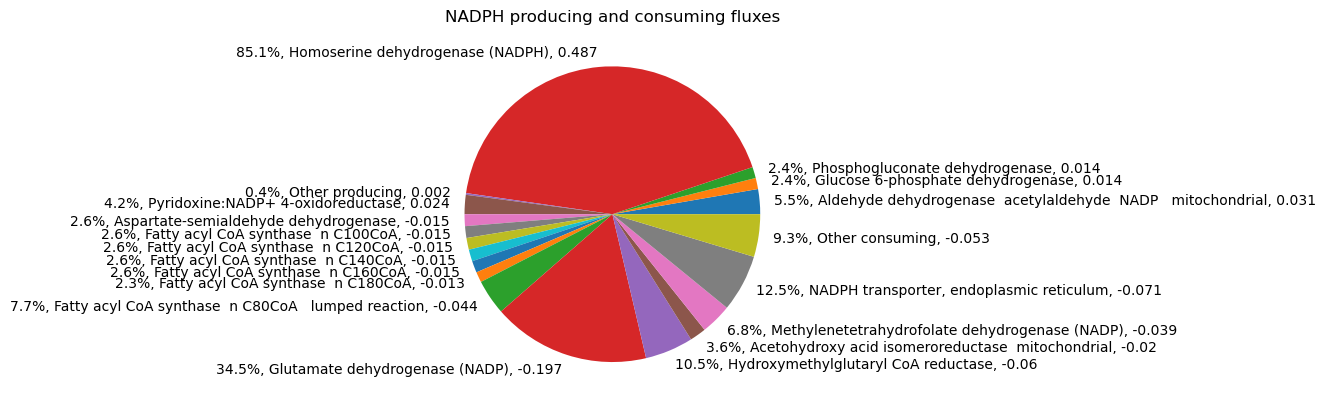

([<matplotlib.patches.Wedge at 0x1c5cab70890>,
 [Text(1.095964776134757, 0.09413399742862265, '5.5%, Aldehyde dehydrogenase  acetylaldehyde  NADP   mitochondrial, 0.031'),
  Text(1.0759337967462927, 0.22883720199982188, '2.4%, Glucose 6-phosphate dehydrogenase, 0.014'),
  Text(1.0553277983799356, 0.3102954043593912, '2.4%, Phosphogluconate dehydrogenase, 0.014'),
  Text(-0.09925801551606273, 1.0955125952520186, '85.1%, Homoserine dehydrogenase (NADPH), 0.487'),
  Text(-1.0896070200615835, 0.1508527156948671, '0.4%, Other producing, 0.002'),
  Text(-1.0976163413327173, 0.07237656554009449, '4.2%, Pyridoxine:NADP+ 4-oxidoreductase, 0.024'),
  Text(-1.099090618990117, -0.04471924918780742, '2.6%, Aspartate-semialdehyde dehydrogenase, -0.015'),
  Text(-1.0918656780191283, -0.13352655602474564, '2.6%, Fatty acyl CoA synthase  n C100CoA, -0.015'),
  Text(-1.0775447896806352, -0.22112717208004046, '2.6%, Fatty acyl CoA synthase  n C120CoA, -0.015'),
  Text(-1.0562074321317048, -0.307287911102

In [16]:
# Make a pie plot for napdh fluxes
threshold = 0.02 # threshold for including reaction in 'others' in pie chart
title = 'NADPH producing and consuming fluxes'
producing_nadph_fluxes_lowest_GR_pie_chart = cofactor_fluxes_pie_chart(nadph_fluxes_lowest_GR, title, threshold)
producing_nadph_fluxes_lowest_GR_pie_chart

In [8]:
# Get nadh fluxes at lowest biomass growth rate

nadh_fluxes_lowest_GR, biomass_GR_lowest = cofactor_all_rxn_fluxes(nadhs, glucose_uptakes[0])
print(biomass_GR_lowest)
nadh_fluxes_highest_GR, biomass_GR_highest = cofactor_all_rxn_fluxes(nadhs, glucose_uptakes[5])
nadh_fluxes_lowest_GR

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
c:\Users\Maive\miniconda3\envs\bachelor_thesis\Lib\site-packages\cobra\medium\boundary_types.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


c:\Users\Maive\miniconda3\envs\bachelor_thesis\Lib\site-packages\cobra\medium\boundary_types.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Biomass growth rate: 0.03396072368468521


Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
c:\Users\Maive\miniconda3\envs\bachelor_thesis\Lib\site-packages\cobra\medium\boundary_types.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


SUM produced: 2.4421963190491165, SUM consumed: -2.442196319049116
0.03396072368468521


c:\Users\Maive\miniconda3\envs\bachelor_thesis\Lib\site-packages\cobra\medium\boundary_types.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Biomass growth rate: 0.23346444027865876
SUM produced: 14.72159543824406, SUM consumed: -14.72159543824406


,flux,reaction,percent
GAPD,0.692249,GAPD,2.834536e-01
MDHm,0.547556,MDHm,2.242066e-01
PDHm,0.534220,PDHm,2.187457e-01
ICDHxm,0.319904,ICDHxm,1.309902e-01
AKGDm,0.279712,AKGDm,1.145328e-01
HICITDm,0.015555,HICITDm,6.369335e-03
IPMD,0.010874,IPMD,4.452711e-03
HACD1m,0.009703,HACD1m,3.972891e-03
2OXOADOXm,0.009703,2OXOADOXm,3.972891e-03
SACCD2,0.005853,SACCD2,2.396444e-03


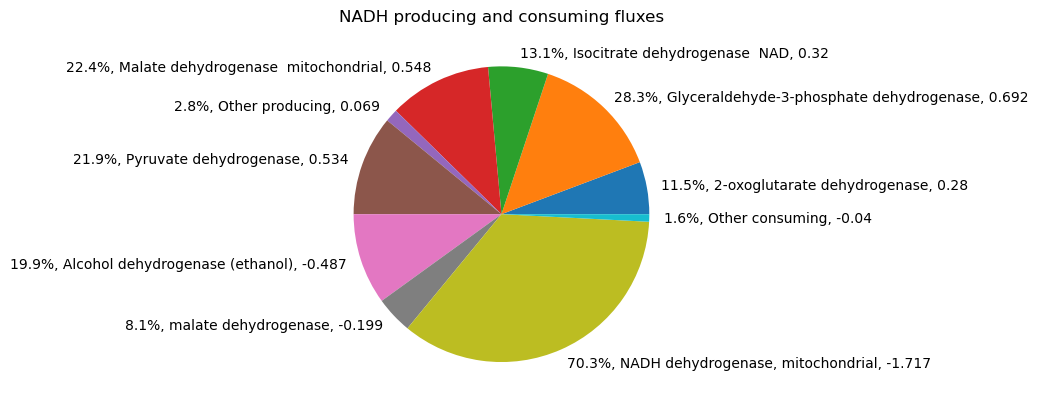

([<matplotlib.patches.Wedge at 0x1c5c9717980>,
 [Text(1.0822462321782644, 0.1968326521082068, '11.5%, 2-oxoglutarate dehydrogenase, 0.28'),
  Text(0.7623721893640335, 0.7929619441589177, '28.3%, Glyceraldehyde-3-phosphate dehydrogenase, 0.692'),
  Text(0.1259222409665772, 1.0927687720785013, '13.1%, Isocitrate dehydrogenase  NAD, 0.32'),
  Text(-0.47173119767648164, 0.9937150885131575, '22.4%, Malate dehydrogenase  mitochondrial, 0.548'),
  Text(-0.8187347475043409, 0.7346246750749688, '2.8%, Other producing, 0.069'),
  Text(-1.0357010565351985, 0.37057161452528126, '21.9%, Pyruvate dehydrogenase, 0.534'),
  Text(-1.0464743614574792, -0.3389563553205066, '19.9%, Alcohol dehydrogenase (ethanol), -0.487'),
  Text(-0.8017311942866703, -0.7531448015539042, '8.1%, malate dehydrogenase, -0.199'),
  Text(0.443776986269636, -1.0065098044517198, '70.3%, NADH dehydrogenase, mitochondrial, -1.717'),
  Text(1.099638031840481, -0.028216997182431435, '1.6%, Other consuming, -0.04')])

In [9]:
# Make a pie plot for nadh  fluxes
threshold = 0.02 # threshold for including reaction in group 'others' in pie chart
title = 'NADH producing and consuming fluxes'
producing_nadh_fluxes_lowest_GR_pie_chart = cofactor_fluxes_pie_chart(nadh_fluxes_lowest_GR, title, threshold)
producing_nadh_fluxes_lowest_GR_pie_chart

In [10]:
# Get atp fluxes at lowest biomass growth rate

atp_fluxes_lowest_GR, biomass_GR_lowest = cofactor_all_rxn_fluxes(atps, glucose_uptakes[0])
print(biomass_GR_lowest)
atp_fluxes_highest_GR, biomass_GR_highest = cofactor_all_rxn_fluxes(atps, glucose_uptakes[5])
atp_fluxes_lowest_GR

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
c:\Users\Maive\miniconda3\envs\bachelor_thesis\Lib\site-packages\cobra\medium\boundary_types.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
c:\Users\Maive\miniconda3\envs\bachelor_thesis\Lib\site-packages\cobra\medium\boundary_types.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer key

Biomass growth rate: 0.03396072368468521


Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
c:\Users\Maive\miniconda3\envs\bachelor_thesis\Lib\site-packages\cobra\medium\boundary_types.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


SUM produced: 7.966086039658074, SUM consumed: -7.966086039658078
0.03396072368468521
Biomass growth rate: 0.23346444027865876


c:\Users\Maive\miniconda3\envs\bachelor_thesis\Lib\site-packages\cobra\medium\boundary_types.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


SUM produced: 47.182778162612884, SUM consumed: -47.182778162612834


,flux,reaction,percent
ATPS3m,6.314545,ATPS3m,0.792679
PGK,0.692249,PGK,0.086900
PYK,0.679536,PYK,0.085304
SUCOASm,0.279524,SUCOASm,0.035089
URIDK2r,0.000231,URIDK2r,0.000029
...,...,...,...
ADK1,-0.217576,ADK1,0.027313
PFK,-0.346383,PFK,0.043482
HEX1,-0.476000,HEX1,0.059753
ATPM,-1.220000,ATPM,0.153149


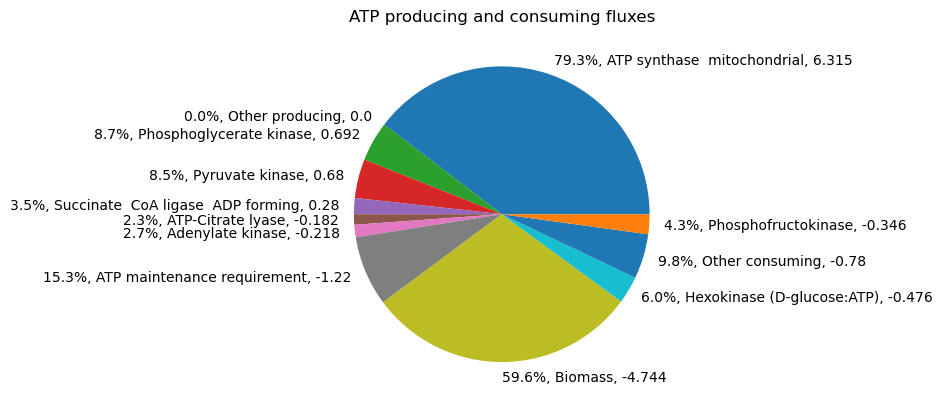

([<matplotlib.patches.Wedge at 0x1c5c72d7200>,
 [Text(0.3519273694144343, 1.0421838257510219, '79.3%, ATP synthase  mitochondrial, 6.315'),
  Text(-0.8748433589226117, 0.6668201386798412, '0.0%, Other producing, 0.0'),
  Text(-0.9574699045702043, 0.5415268985399749, '8.7%, Phosphoglycerate kinase, 0.692'),
  Text(-1.0673559820075107, 0.26599099171359686, '8.5%, Pyruvate kinase, 0.68'),
  Text(-1.0983295233522727, 0.06059915950547016, '3.5%, Succinate  CoA ligase  ADP forming, 0.28'),
  Text(-1.0992888150681854, -0.03954871762756636, '2.3%, ATP-Citrate lyase, -0.182'),
  Text(-1.0927563312529744, -0.12603015713129753, '2.7%, Adenylate kinase, -0.218'),
  Text(-1.0138963862346846, -0.42663112636122513, '15.3%, ATP maintenance requirement, -1.22'),
  Text(0.003847657630875569, -1.0999932706752145, '59.6%, Biomass, -4.744'),
  Text(0.9446063646991649, -0.5636655176341981, '6.0%, Hexokinase (D-glucose:ATP), -0.476'),
  Text(1.053950664277562, -0.314941260029368, '9.8%, Other consuming, -0.7

In [11]:
# Make a pie plot for atp  fluxes
threshold = 0.02 # threshold for including reaction in group 'others' in pie chart
title = 'ATP producing and consuming fluxes'
producing_atps_fluxes_lowest_GR_pie_chart = cofactor_fluxes_pie_chart(atp_fluxes_lowest_GR, title,  threshold)
producing_atps_fluxes_lowest_GR_pie_chart

In [12]:
# # Get cofactor data to excel
# with pd.ExcelWriter('C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Results\\Rt_IFO0880_jsb_results\\Rt_IFO0880_jsb_all_cofactor_fluxes.xlsx') as excel_writer:
#     nadph_fluxes_lowest_GR.to_excel(excel_writer, sheet_name=f'NADPH fluxes, GR = {round(biomass_GR_lowest, 2)}', index=False)
#     nadph_fluxes_highest_GR.to_excel(excel_writer, sheet_name=f'NADPH fluxes, GR = {round(biomass_GR_highest, 2)}', index=False)
#     nadh_fluxes_lowest_GR.to_excel(excel_writer, sheet_name=f'NADH fluxes, GR = {round(biomass_GR_lowest, 2)}', index=False)
#     nadh_fluxes_highest_GR.to_excel(excel_writer, sheet_name=f'NADH fluxes, GR = {round(biomass_GR_highest, 2)}', index=False)
#     atp_fluxes_lowest_GR.to_excel(excel_writer, sheet_name=f'ATP fluxes, GR = {round(biomass_GR_lowest, 2)}', index=False)
#     atp_fluxes_highest_GR.to_excel(excel_writer, sheet_name=f'ATP fluxes, GR = {round(biomass_GR_highest, 2)}', index=False)
